#              Vibration-Based Condition Monitoring of Rolling Bearings

This code is related to the following section of [the paper](https://arxiv.org/abs/2403.17181):

## Section VII: Applications
### A. Vibration-Based Condition Monitoring of Rolling Bearings

The section is a demonstration of condition monitoring of rolling bearings, where the power spectral density (PSD) of the generated vibration is analyzed to extract features indicative of the operational health of the machine.

For more details please refer to [the paper](https://arxiv.org/abs/2403.17181).

In [1]:
from scipy.io import loadmat
from numpy import asarray
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
from scipy import signal
from scipy.signal import welch
from scipy.stats import entropy
import os
import glob
from warnings import warn
from sklearn import metrics
plt.rc('font',family='Times New Roman')
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Function to compute PSD

def compute_psd(signal, fs):
    seg_length =  512 # Segment length.
    overlap = seg_length/2 # overlap between segements (in number of samples)
    nfft_length = 1024 # FFT length
    frequencies, psd = welch(signal,  fs = fs, window='hann', nperseg= seg_length, noverlap= overlap, nfft= nfft_length)
    
    return frequencies, psd

In [3]:
# Function to calculate spectral features from the PSD

def spectral_features(signal, fs):
    # Calculate the Power Spectral Density (PSD) using Welch's method
    frequencies, psd = compute_psd(signal, fs)

    # Normalize the PSD
    psd_norm = psd / np.sum(psd)

    # Calculate the Spectral Centroid
    spectral_centroid = np.sum(frequencies * psd_norm)

    # Calculate the Spectral Spread (second central moment)
    spectral_spread = np.sqrt(np.sum(((frequencies - spectral_centroid) ** 2) * psd_norm))
   
    # Calculate the Spectral Entropy
    spectral_entropy = entropy(psd)
    
    peak_freq = frequencies[np.argmax(psd)] # freq. of peak power in the PSD
    
    peak_pwr = np.max(psd) # Peak power in the PSD.
    

    return spectral_centroid, spectral_spread, spectral_entropy, peak_freq, peak_pwr

In [4]:
def make_dataset(data_src, num_samples, class_):
    files = glob.glob(data_src)
    files = np.sort(files)
    data = loadmat(files[0])
    keysList = sorted(data.keys())
    key = keysList[0]
    drive_end_data = data[key]['Y'][0][0][0][6][2]
    drive_end_data = drive_end_data.reshape(-1)
    num_segments = np.floor(len(drive_end_data)/num_samples)
    slices = np.split(drive_end_data[0:int(num_segments*num_samples)], num_samples)
    silces = np.array(slices).reshape(int(num_segments), num_samples)
    segmented_data = silces
    files = files[1:]
    for file in files:
        data = loadmat(file)
        keysList = sorted(data.keys())
        key = keysList[0]
        drive_end_data = data[key]['Y'][0][0][0][6][2]
        drive_end_data = drive_end_data.reshape(-1)
        num_segments = np.floor(len(drive_end_data)/num_samples)
        slices = np.split(drive_end_data[0:int(num_segments*num_samples)], num_samples)
        silces = np.array(slices).reshape(int(num_segments), num_samples)
        segmented_data = np.concatenate( (segmented_data, silces) , axis=0, out=None)
    
    segmented_data = np.unique(segmented_data, axis= 0) # remove duplicates
    #np.random.shuffle( segmented_data) # suffule the data
    Class_ = np.ones(len(segmented_data))*class_
    #segmented_data = segmented_data[:2401]; Class_ = Class_[:2401] # Max. based on 12,800 samples !
    print(segmented_data.shape)
    print(Class_.shape)
    
    return segmented_data, Class_

==========================================================================================================================
# Dataset Creatioin:
=========================================================================================================================== 

## Grouping vibration signals in required folders to  generate the dataset
 
Link to download the PU dataset: https://mb.uni-paderborn.de/en/kat/main-research/datacenter/bearing-datacenter/data-sets-and-download <br>
After downloading the dataset, vibration signals to be grouped according to their operational conditions/properties in 4 folders (corresponding to number of operational classes in the dataset: 1 normal class and 3 faulty classes) with below folder names:

1.	Healthy
2.	IR&OR
3.	IR
4.	OR

*IR&OR =  Inner Race faults and Outter Race faults <br>
*IR = Inner Race fault <br>
*OR = Outer Race faults <br>


In [5]:
num_samples = 12800 # Length of input segment
###########################################
fs = 64000; # Sampling freq.

In [6]:
data_path = (r"D:\dataset") # path to the 4 folders.


cls_1 = 'Healthy/*'; cls_2 = 'IR&OR/*'; cls_3 = 'IR/*'; cls_4 = 'OR/*' # Operational classes in the dataset

norm, y_norm   = make_dataset(os.path.join(data_path, cls_1), num_samples, 0)
defc1, y_defc1 = make_dataset(os.path.join(data_path, cls_2), num_samples, 1)
defc2, y_defc2 = make_dataset(os.path.join(data_path, cls_3), num_samples, 2)
defc3, y_defc3 = make_dataset(os.path.join(data_path, cls_4), num_samples, 3)


(2401, 12800)
(2401,)
(1198, 12800)
(1198,)
(2400, 12800)
(2400,)
(1998, 12800)
(1998,)


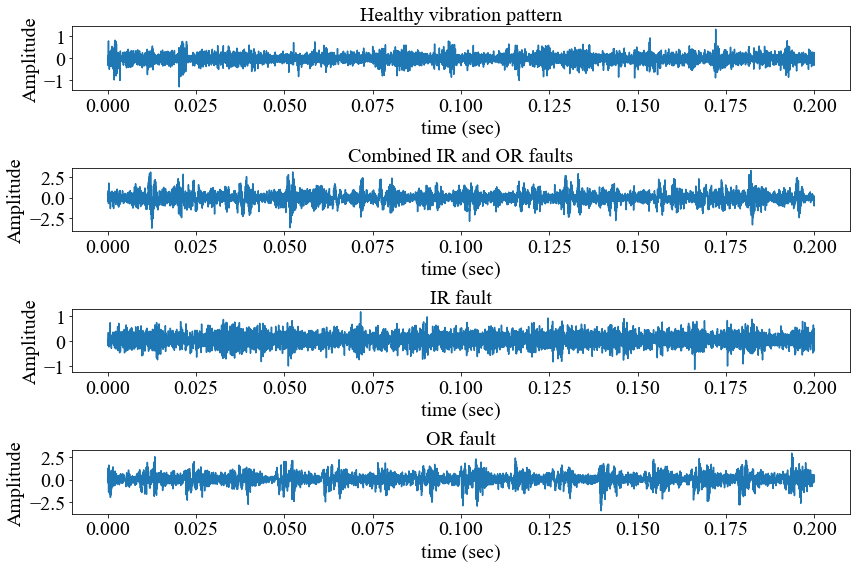

In [7]:
#  Sample vibration patterns representing operational conditions in the PU dataset

index = 1000
healthy_vib = norm[index]
IR_and_OR = defc1[index]
IR = defc2[index]
OR = defc3[index]
time = np.arange(0.0, len(healthy_vib), 1.0)/fs
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.tick_params('x', labelsize=20)
plt.tick_params('y', labelsize=20)
plt.plot(time, healthy_vib)
plt.xlabel('time (sec)', fontsize = 20)
plt.ylabel('Amplitude', fontsize = 20)
plt.title("Healthy vibration pattern", fontsize = 20)
plt.subplot(4, 1, 2)
plt.tick_params('x', labelsize=20)
plt.tick_params('y', labelsize=20)
plt.plot(time, IR_and_OR)
plt.xlabel('time (sec)', fontsize = 20)
plt.ylabel('Amplitude', fontsize = 20)
plt.title("Combined IR and OR faults", fontsize = 20)
plt.subplot(4, 1, 3)
plt.tick_params('x', labelsize=20)
plt.tick_params('y', labelsize=20)
plt.plot(time, IR)
plt.xlabel('time (sec)', fontsize =20)
plt.ylabel('Amplitude', fontsize = 20)
plt.title("IR fault", fontsize = 20)
plt.subplot(4, 1, 4)
plt.tick_params('x', labelsize=20)
plt.tick_params('y', labelsize=20)
plt.plot(time, OR)
plt.xlabel('time (sec)', fontsize = 20)
plt.ylabel('Amplitude', fontsize = 20)
plt.title("OR fault", fontsize = 20)
plt.tight_layout()
plt.show()

In [8]:
X = np.concatenate( (norm, defc1, defc2, defc3) , axis=0, out=None)
Y = np.concatenate( (y_norm, y_defc1, y_defc2, y_defc3), axis=0, out=None)

print("data set features size:", X.shape)
print("data set labels size:", Y.shape)
print(X.shape)

data set features size: (7997, 12800)
data set labels size: (7997,)
(7997, 12800)


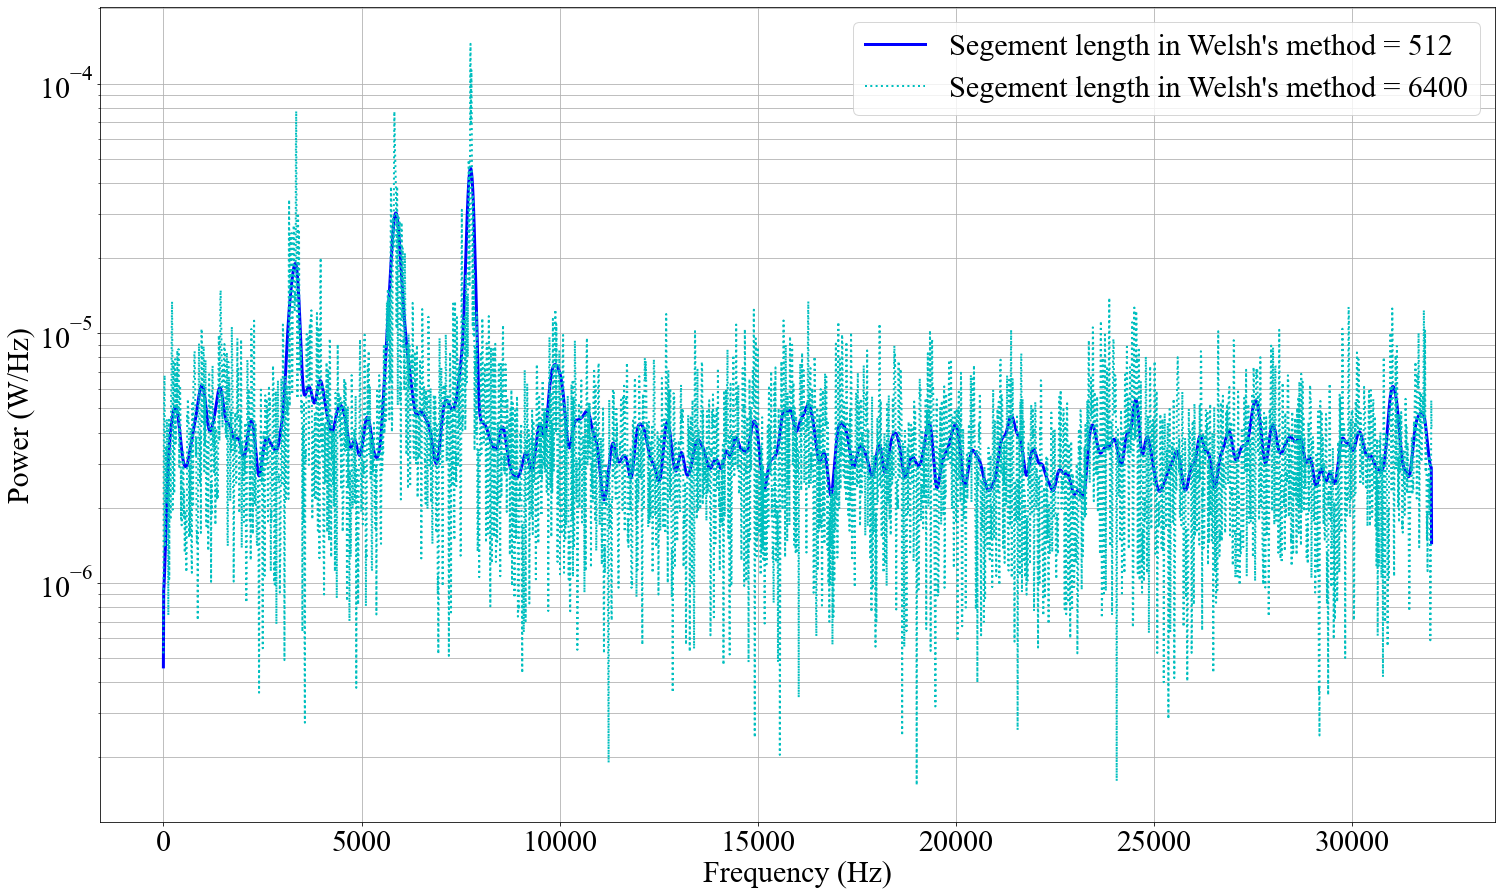

In [9]:
# Two different estimations of the PSD using short and large segments in the Welsh method
signal = X[0]

f1, psd1 = welch(signal,  fs = fs, window='hann', nperseg= 512, noverlap= 512/2, nfft= 8192) # Short segments
f2, psd2 = welch(signal,  fs = fs, window='hann', nperseg= 6400, noverlap= 6400/2, nfft= 8192) # Large segments


plt.figure(figsize=(25, 15))
plt.grid(True, which ="both")
plt.semilogy(f1, psd1, linewidth=3, color='b', label = "Segement length in Welsh's method = 512")
plt.semilogy(f2, psd2,linewidth= 2, linestyle=":", color='c',  label = "Segement length in Welsh's method = 6400")
plt.xlabel('Frequency (Hz)', fontsize = 30)
plt.ylabel('Power (W/Hz)', fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.tick_params(axis='both', which='minor', labelsize= 30)
plt.legend(fontsize=30)
plt.show()

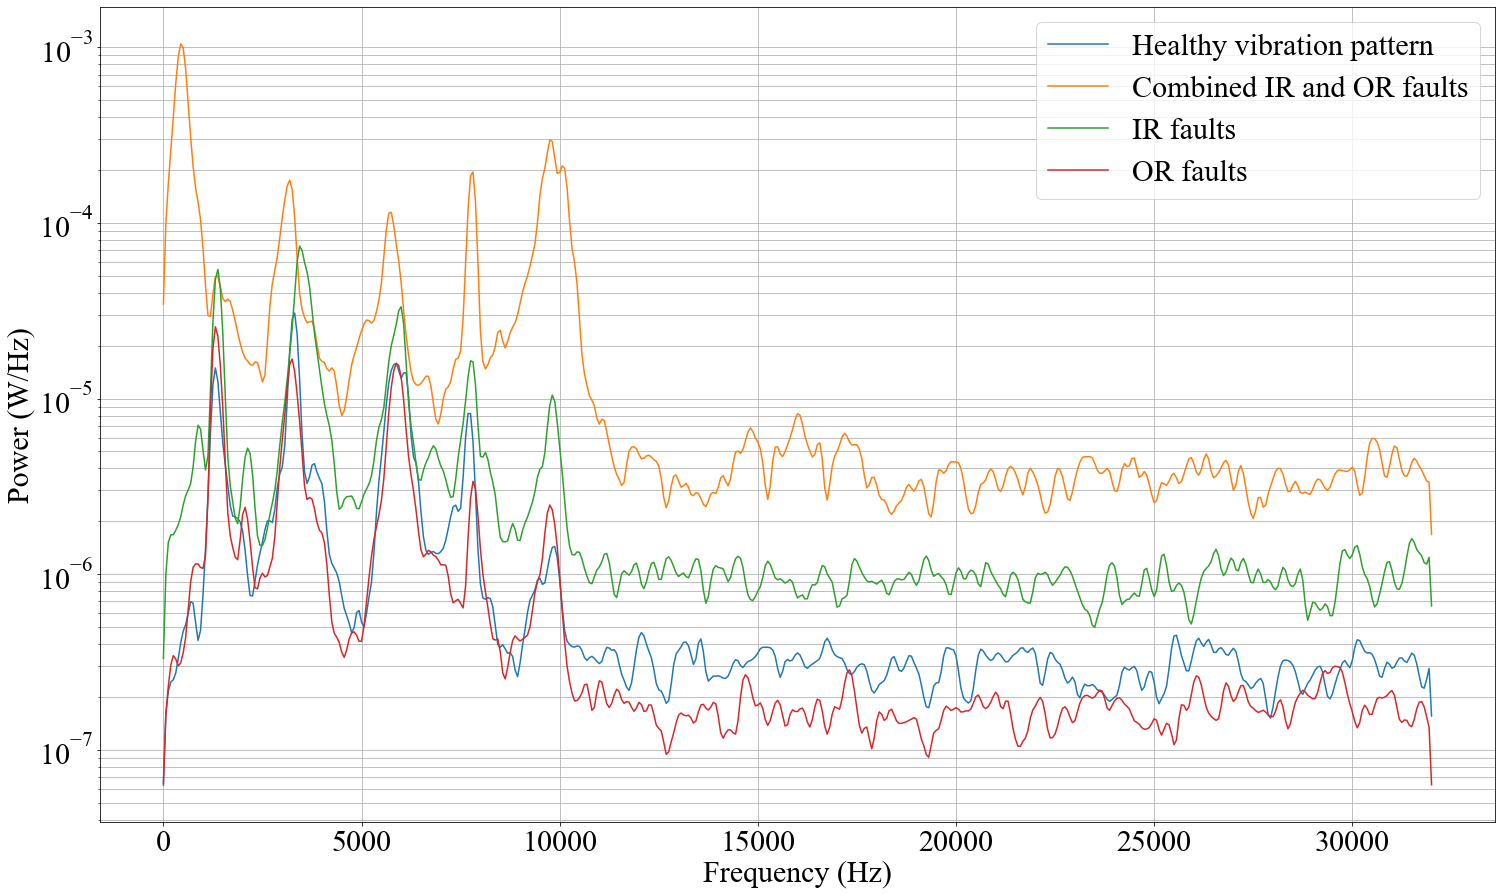

In [10]:
# PSD estimates of four vibration samples representing healthy and abnormal operational conditions in the dataset

index = 100
f1, psd1 = compute_psd(norm[index],  fs)
f2, psd2 = compute_psd(defc1[index],  fs)
f3, psd3 = compute_psd(defc2[index],  fs)
f4, psd4 = compute_psd(defc3[index],  fs)

plt.figure(figsize=(25, 15))
plt.grid(True, which ="both")
plt.semilogy(f1, psd1, label = 'Healthy vibration pattern')
plt.semilogy(f2, psd2, label = 'Combined IR and OR faults')
plt.semilogy(f3, psd3, label = 'IR faults')
plt.semilogy(f4, psd4, label = 'OR faults')
plt.xlabel('Frequency (Hz)', fontsize = 30)
plt.ylabel('Power (W/Hz)', fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.tick_params(axis='both', which='minor', labelsize= 30)
plt.legend(fontsize=30)
plt.show()

In [11]:
# Features calculation

num_signals = len(X)
num_features = 5
feature_matrix = np.zeros((num_signals, num_features))  # Initialize a matrix to store the features

# Loop over 10 signals
for i in range(num_signals):
    #analytic_signal = hilbert( X[i])
    #amplitude_envelope = np.abs(analytic_signal)
    spectral_centroid, spectral_spread, spectral_entropy, peak_freq, peak_pwr = spectral_features(X[i], fs)
    
    # Store the features in the matrix
    feature_matrix[i, :] = [spectral_centroid, spectral_spread, spectral_entropy, peak_freq, peak_pwr]
    
print(feature_matrix.shape)

(7997, 5)


In [12]:
from skopt import Optimizer
from skopt import BayesSearchCV 
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix

In [13]:
labels = Y 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, labels, test_size = 0.3, 
                                                    shuffle = True, stratify = labels, random_state = 42)

In [15]:
X_train.shape

(5597, 5)

In [16]:
X_test.shape

(2400, 5)

In [17]:
scaler =MinMaxScaler()
train_data_scaled = scaler.fit_transform(X_train)
test_data_scaled = scaler.transform(X_test)

In [18]:
clf_RF = RandomForestClassifier(criterion='entropy', max_features = 1, min_samples_leaf=1, min_samples_split=2, 
                                max_depth=200, n_estimators=1000, random_state= 42)
best_clf = clf_RF.fit(train_data_scaled, y_train)

ROC AUC = 1.000
F1 Score = 0.9941666666666666
Accuracy = 99.417 %


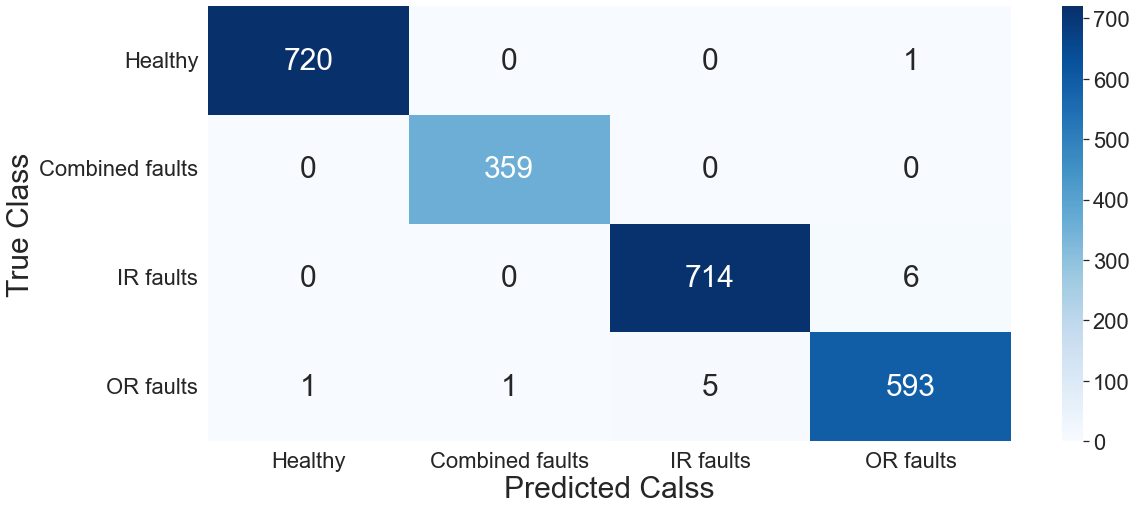

In [19]:
test_predictions = best_clf.predict(test_data_scaled)
test_confu_matrix = confusion_matrix(y_test, test_predictions)
fault_type = ['Healthy','Combined faults','IR faults','OR faults']
plt.figure(1,figsize=(18,8))
sns.set(font_scale=2)
sns.heatmap(test_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", annot_kws={"size": 30})
plt.xlabel('Predicted Calss', fontsize = 30)
plt.ylabel('True Class', fontsize = 30)
Accuracy = metrics.accuracy_score(y_test, test_predictions)
F1_score = metrics.f1_score(y_test, test_predictions, average='micro')
probs = best_clf.predict_proba(test_data_scaled)
lr_auc = roc_auc_score(y_test, probs, multi_class='ovr')
print('ROC AUC = %.3f' % (lr_auc))
print("F1 Score =", F1_score)
print("Accuracy = %.3f" % (Accuracy*100), "%")